# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib2'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib2.assembled.dmult.fastq')

# number of processors
nprocs = 10

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib2/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib2/pear_merged-fullCyc2_lib2.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib2.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 4371176
Number of sequences post-filter: 4346981

>MR.M.13C-Ami.D14.R1_Frac10_bad_0 orig_name=M01032:439:000000000-ATCLE:1:1101:15859:1832
TCCGTAGGGTGCGAGCGTTATTCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGCCGGATGTGAAATCCC
CGGGCTTAACCTGGGAATGGCATTCGGGACTGCAAGGCTGGAGTGCGGCAGAGGAGACTGGAATTCCTGGTGTAGCAGTG
AAATGCGTAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCTGACACTGACGCTTATGCACGAAAGCGTG
GGGAGCAAACAGG
>MR.M.13C-Van.D14.R1_Frac5_1 orig_name=M01032:439:000000000-ATCLE:1:1101:17364:1908
TACGGAGGGTGCAAGCGTTATTCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCGTTGTAAGACTGTCGTGAAATCCC
CGGGCTTAACCTGGGAATGGCGATGGTGACTGCAAGGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 4346981
Number of sequences post-filter: 4346981


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.M.13C-Ami.D14.R1_Frac10_bad_0	MR.M.13C-Ami.D14.R1_Frac10_bad
MR.M.13C-Van.D14.R1_Frac5_1	MR.M.13C-Van.D14.R1_Frac5
MR.M.13C-Ami.D14.R1_Frac26_bad_2	MR.M.13C-Ami.D14.R1_Frac26_bad
MR.M.12C-Con.D1.R1_Frac8_4	MR.M.12C-Con.D1.R1_Frac8
MR.M.13C-Ami.D14.R1_Frac5_bad_3	MR.M.13C-Ami.D14.R1_Frac5_bad
MR.M.13C-Ami.D14.R1_Frac23_bad_6	MR.M.13C-Ami.D14.R1_Frac23_bad
MR.F.13C-Cel.D30.R3_Frac16_7	MR.F.13C-Cel.D30.R3_Frac16
MR.F.13C-Pal.D6.R1_Frac16_8	MR.F.13C-Pal.D6.R1_Frac16
MR.M.13C-Van.D14.R1_Frac20_5	MR.M.13C-Van.D14.R1_Frac20
MR.M.13C-Ami.D14.R1_Frac19_bad_12	MR.M.13C-Ami.D14.R1_Frac19_bad


In [13]:
! head -n 200 group_file.txt

MR.M.13C-Ami.D14.R1_Frac10_bad_0	MR.M.13C-Ami.D14.R1_Frac10_bad
MR.M.13C-Van.D14.R1_Frac5_1	MR.M.13C-Van.D14.R1_Frac5
MR.M.13C-Ami.D14.R1_Frac26_bad_2	MR.M.13C-Ami.D14.R1_Frac26_bad
MR.M.12C-Con.D1.R1_Frac8_4	MR.M.12C-Con.D1.R1_Frac8
MR.M.13C-Ami.D14.R1_Frac5_bad_3	MR.M.13C-Ami.D14.R1_Frac5_bad
MR.M.13C-Ami.D14.R1_Frac23_bad_6	MR.M.13C-Ami.D14.R1_Frac23_bad
MR.F.13C-Cel.D30.R3_Frac16_7	MR.F.13C-Cel.D30.R3_Frac16
MR.F.13C-Pal.D6.R1_Frac16_8	MR.F.13C-Pal.D6.R1_Frac16
MR.M.13C-Van.D14.R1_Frac20_5	MR.M.13C-Van.D14.R1_Frac20
MR.M.13C-Ami.D14.R1_Frac19_bad_12	MR.M.13C-Ami.D14.R1_Frac19_bad
MR.F.13C-Pal.D6.R1_Frac24_11	MR.F.13C-Pal.D6.R1_Frac24
MR.M.13C-Van.D14.R1_Frac17_14	MR.M.13C-Van.D14.R1_Frac17
MR.F.13C-Cel.D6.R2_Frac12_9	MR.F.13C-Cel.D6.R2_Frac12
MR.F.13C-Pal.D6.R1_Frac26_13	MR.F.13C-Pal.D6.R1_Frac26
MR.M.13C-Ami.D14.R1_Frac18_bad_16	MR.M.13C-Ami.D14.R1_Frac18_bad
MR.F.13C-Pal.D6.R1_Frac8_15	MR.F.13C-Pal.D6.R1_Frac8
MR.F.13C-Cel.D6.R2_Frac23_10	MR.F.13C-Cel.D6.R2_Frac23
MR.M.13C-Cel.D1

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

4325000	2101431
4326000	2101869
4327000	2102310
4328000	2102756
4329000	2103203
4330000	2103653
4331000	2104072
4332000	2104515
4333000	2104974
4334000	2105429
4335000	2105891
4336000	2106346
4337000	2106804
4338000	2107278
4339000	2107738
4340000	2108260
4341000	2108835
4342000	2109507
4343000	2110150
4344000	2110817
4345000	2111506
4346000	2112250
4346981	2113042

Output File Names: 
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 2113042


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 214M May 15 12:50 pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-15 12:50:47--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.89M 10s
    50K .......... .......... .......... .......... ..........  0%  989K 15s
   100K .......... .......... .......... .......... ..........  0% 1.88M 13s
   150K .......... .......... .......... .......... ..........  1%  991K 14s
   200K .......... .......... .......... .......... ..........  1% 1.87M 14s
   250K .......... .......... .......... .......... ..........  1%  994K 14s
   300K .......... .......... .......... .......... ..........  1% 1.86M 14s
   350K .......... .......... .......... .......... ..........  2%  993K 14s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

700
800
900
1000
1100
1118



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [24]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

211200
211300
211400
211500
211600
211700
211800
211900
212000
212016
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1194 secs to align 2113042 sequences.


Output File Names: 
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.align
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>

In [25]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 21G May 15 13:15 pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.align


In [26]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

209900
210000
210100
210200
210300
210400
210500
210600
210700
210800
210900
211000
211100
211200
211300
211327



Length of filtered alignment: 1190
Number of columns removed: 8990
Length of the original alignment: 10180
Number of sequences used to construct filter: 2113042

Output File Names: 
pear_merged-fullCyc2_lib2.filter
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [27]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 2.5G May 15 13:17 pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.fasta


In [28]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	208	944	253	0	4	108675
25%-tile:	208	944	253	0	4	1086746
Median: 	208	944	253	0	5	2173491
75%-tile:	208	944	253	0	6	3260236
97.5%-tile:	208	944	254	0	8	4238307
Maximum:	1190	1190	352	0	75	4346981
Mean:	209.681	943.988	252.491	0	4.93499
# of unique seqs:	2113042
total # of seqs:	4346981

Output File Names: 
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.summary

It took 16 secs to summarize 4346981 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [29]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 208, 944)
!$cmd | tail -n 30

Processing sequence: 209700
Processing sequence: 209800
Processing sequence: 209900
Processing sequence: 210000
Processing sequence: 210100
Processing sequence: 210200
Processing sequence: 210300
Processing sequence: 210400
Processing sequence: 210500
Processing sequence: 210600
Processing sequence: 210700
Processing sequence: 210800
Processing sequence: 210900
Processing sequence: 211000
Processing sequence: 211100
Processing sequence: 211200
Processing sequence: 211300
Processing sequence: 211400
Processing sequence: 211487

Output File Names: 
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 32 secs to screen 2113042 sequences.

mothur > quit()


In [30]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 2072681


In [31]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

207000
207100
207200
207300
207400
207447



Length of filtered alignment: 940
Number of columns removed: 250
Length of the original alignment: 1190
Number of sequences used to construct filter: 2072681

Output File Names: 
pear_merged-fullCyc2_lib2.filter
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [32]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 1.9G May 15 13:19 pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [33]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-fullCyc2_lib2.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [34]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [35]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	202	202	0	3	1
2.5%-tile:	1	253	253	0	4	106897
25%-tile:	1	253	253	0	4	1068967
Median: 	1	253	253	0	5	2137933
75%-tile:	1	253	253	0	6	3206899
97.5%-tile:	1	254	254	0	8	4168969
Maximum:	1	352	352	0	8	4275865
Mean:	1	253.065	253.065	0	4.9249
# of Seqs:	4275865

Output File Names: 
finalQC.summary

It took 6 secs to summarize 4275865 sequences.

mothur > quit()


In [36]:
!head -n 6 $qcFinal

>MR.M.13C-Ami.D14.R1_Frac10_bad_0
TCCGTAGGGTGCGAGCGTTATTCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTTGTAAGCCGGATGTGAAATCCCCGGGCTTAACCTGGGAATGGCATTCGGGACTGCAAGGCTGGAGTGCGGCAGAGGAGACTGGAATTCCTGGTGTAGCAGTGAAATGCGTAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCTGACACTGACGCTTATGCACGAAAGCGTGGGGAGCAAACAGG
>MR.M.13C-Van.D14.R1_Frac5_1
TACGGAGGGTGCAAGCGTTATTCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCGTTGTAAGACTGTCGTGAAATCCCCGGGCTTAACCTGGGAATGGCGATGGTGACTGCAAGGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCGGTGGCGAAGGCAGCTCCCTGGGTCAAAACTGACGCTGAGGCACGAAGGCGTGGGGAGCAAACGGG
>MR.M.13C-Ami.D14.R1_Frac26_bad_2
TACAGAGGTCTCAAGCGTTGTTCGGATTCATTGGGCGTAAAGGGTGCGTAGGCGGCGCGGTAAGTCGGGTGTGAAATCTCGGGGCTTAACTCCGAAACTGCATTCGATACTGCCGTGCTTGAGGACTGGAGAGGAGACTGGAATTTACGGTGTAGCGGTGAAATGCGTAGATATCGTAAGGAAGACCAGTGGCGAAGGCGGGTCTCTGGACAGTTCCTGACGCTGAGGCACGAAGGCCAGGGGAGCAAACGGG


## Summary of number of seqs per sample

In [37]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [38]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.M.13C-Ami.D14.R1_Frac10_bad,44591
1,MR.M.13C-Van.D14.R1_Frac5,22264
2,MR.M.13C-Ami.D14.R1_Frac26_bad,33565
3,MR.F.13C-Cel.D6.R2_Frac24,16086
4,MR.F.13C-Cel.D30.R3_Frac24,21011
5,MR.F.13C-Pal.D6.R1_Frac24,26771
6,MR.M.13C-Ami.D14.R1_Frac23_bad,20606
7,MR.F.13C-Cel.D30.R3_Frac27,14551
8,MR.F.13C-Cel.D30.R3_Frac6,65486
9,MR.F.13C-Cel.D30.R3_Frac22,19518


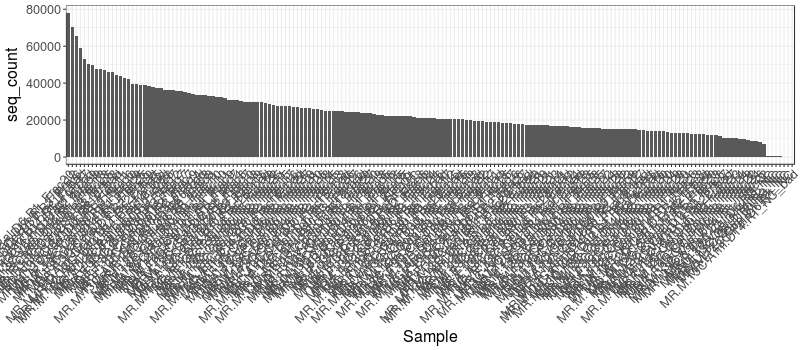

In [39]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [40]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                        Sample seq_count rank
168  MR.M.12C-Con.D1.R1_Frac14      9611   14
169  MR.M.12C-Con.D1.R1_Frac24      9563   13
170 MR.F.13C-Cel.D30.R3_Frac19      9182   12
171  MR.F.13C-Cel.D6.R2_Frac22      8845   11
172 MR.M.13C-Van.D14.R1_Frac24      8662   10
173 MR.M.13C-Van.D14.R1_Frac26      8001    9
174  MR.M.12C-Con.D1.R1_Frac22      6945    8
175      MR.F.13C-Cel.D6.R2_NC       335    7
176     MR.M.13C-Van.D14.R1_NC       331    6
177     MR.M.13C-Cel.D14.R2_NC       314    5
178     MR.F.13C-Cel.D30.R3_NC       299    4
179      MR.M.12C-Con.D1.R1_NC       230    3
180      MR.F.13C-Pal.D6.R1_NC       120    2
181 MR.M.13C-Ami.D14.R1_NC_bad       104    1
